In [31]:
# enable autoreload
%load_ext autoreload
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [32]:
import sys, os
import pathlib
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from monai.losses import DiceCELoss

# include project src in path
sys.path.append(os.path.abspath("src"))
from inference import run_inference, evaluate
from monai.losses import DiceCELoss
import nibabel as nib
from matplotlib.colors import ListedColormap


In [46]:
# set parameters
DATA_DIR       = "/datasets/tdt4265/mic/open/HNTS-MRG"
CHECKPOINT     = "results/exp20_nnunet/checkpoints/best.ckpt"
OUTPUT_DIR     = "results/inference"
BATCH_SIZE     = 2
MODEL_TYPE     = "nnunet"
DEVICE         = torch.device("cuda:0")      

# run inference and grab model + loader
model, test_loader = run_inference(
    data_dir   = DATA_DIR,
    checkpoint = CHECKPOINT,
    output_dir = OUTPUT_DIR,
    batch_size = BATCH_SIZE,
    model_type = MODEL_TYPE,
    device     = DEVICE,
    save_labels= True,
)

Loading dataset: 100%|██████████| 20/20 [00:17<00:00,  1.12it/s]


Inference done; outputs in results/inference


In [47]:
loss_fn = DiceCELoss(
    to_onehot_y=True, softmax=True,
    weight=torch.tensor([0.4,1.5,1.5]).to(DEVICE),
    lambda_dice=0.7, lambda_ce=0.3
)

# evaluate the model on the test set
metrics = evaluate(
    model=model,
    dataloader=test_loader,
    loss_criterion=loss_fn, 
    device=DEVICE
)

# print the metrics
for key, value in metrics.items():
    print(f"{key}: {value:.4f}")



avg_loss: 0.4144
mean_dice: 0.5205
dice_class1: 0.4973
dice_class2: 0.5437
prec_class1: 0.5830
recall_class1: 0.6420
prec_class2: 0.6682
recall_class2: 0.6197


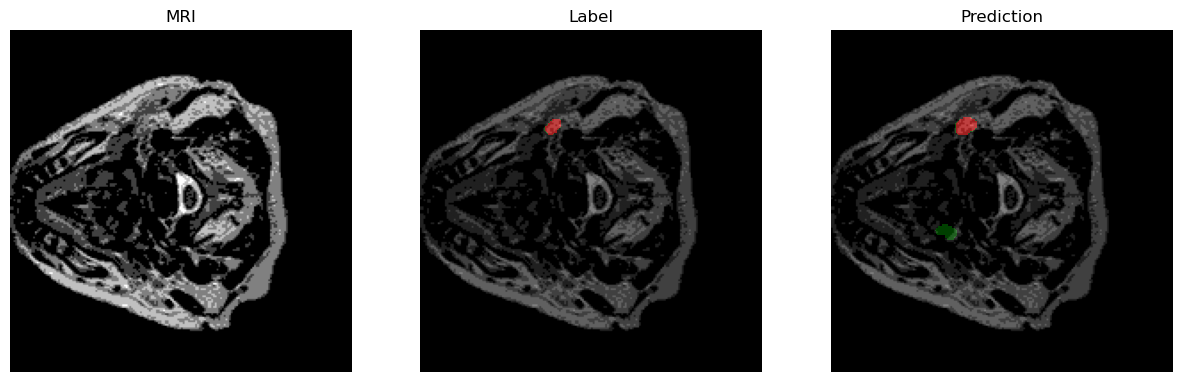

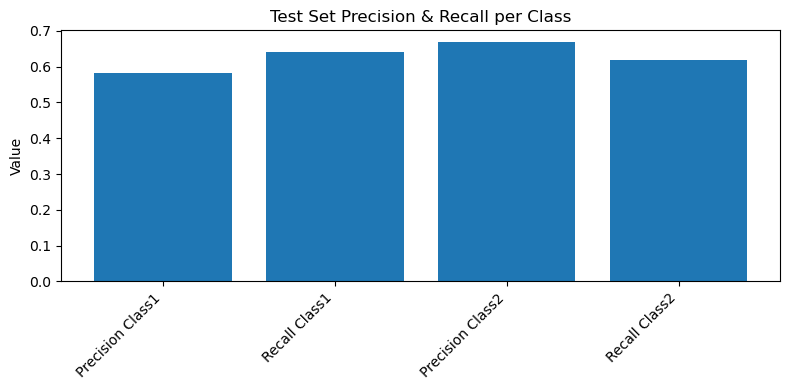

In [48]:
# ## Visualize Sample Predictions

def load_nifti(path):
    return nib.load(str(path)).get_fdata()

cmap = ListedColormap(["black", "green", "red"])

def visualize_slice(image_path, label_path, pred_path, slice_idx=None):
    img = load_nifti(image_path)
    lab = load_nifti(label_path)
    pred = load_nifti(pred_path)

    if slice_idx is None:
        slice_idx = img.shape[-1] // 2
    if lab.ndim == 4:
        lab = np.argmax(lab, axis=0)
    if pred.ndim == 4:
        pred = np.argmax(pred, axis=0)

    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    for ax, data, title in zip(
        axes,
        [img, lab, pred],
        ["MRI", "Label", "Prediction"]
    ):
        ax.imshow(img[:, :, slice_idx], cmap="gray")
        if title != "MRI":
            ax.imshow(data[:, :, slice_idx], cmap=cmap, alpha=0.5, vmin=0, vmax=2)
        ax.set_title(title)
        ax.axis("off")
    plt.show()

# Visualize a specific sample
visualize_slice(
    image_path     = f"{OUTPUT_DIR}/image_2.nii.gz",
    label_path     = f"{OUTPUT_DIR}/label_2.nii.gz",
    pred_path= f"{OUTPUT_DIR}/prediction_2.nii.gz",
    slice_idx      = 30
)

# ## Analysis of Test Metrics
# Bar chart of per-class precision and recall
perf = {
    "Precision Class1": metrics["prec_class1"],
    "Recall Class1": metrics["recall_class1"],
    "Precision Class2": metrics["prec_class2"],
    "Recall Class2": metrics["recall_class2"],
}

plt.figure(figsize=(8, 4))
plt.bar(perf.keys(), perf.values())
plt.xticks(rotation=45, ha="right")
plt.ylabel("Value")
plt.title("Test Set Precision & Recall per Class")
plt.tight_layout()
plt.show()


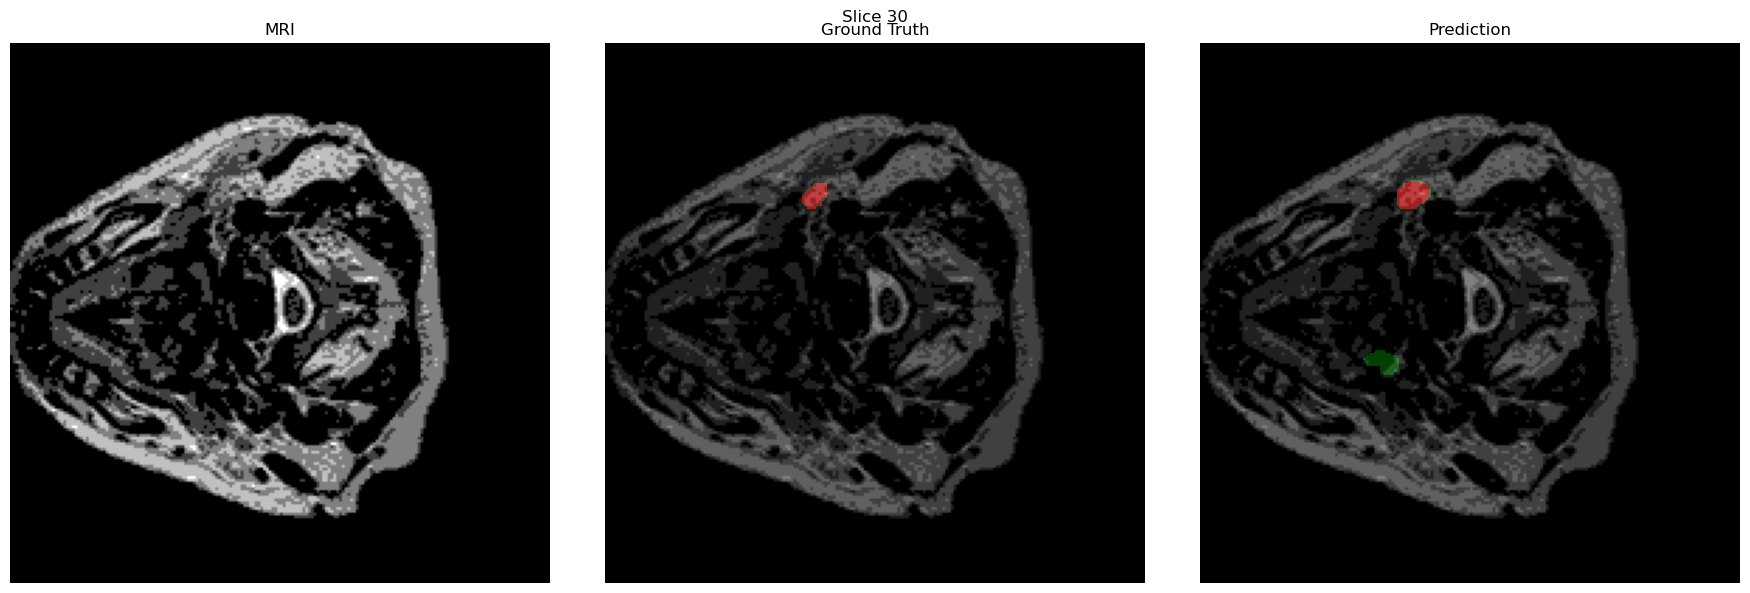

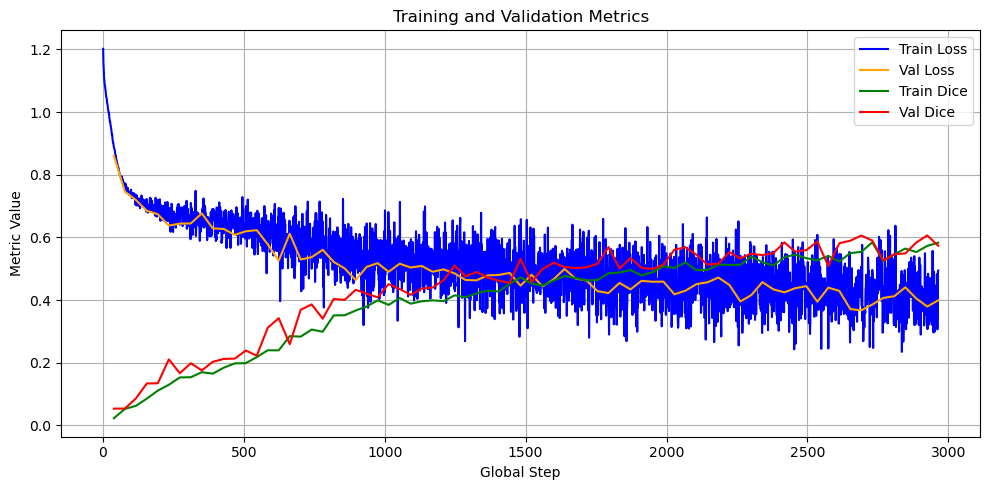

In [49]:
def load_nifti(file_path):
    return nib.load(file_path).get_fdata()

def visualize_slices(image_path, label_path, prediction_path, slice_idx=None):
    image = load_nifti(image_path)
    label = load_nifti(label_path)
    prediction = load_nifti(prediction_path)

    if slice_idx is None:
        slice_idx = image.shape[-1] // 2

    if label.ndim == 4:
        label = np.argmax(label, axis=0)
    if prediction.ndim == 4:
        prediction = np.argmax(prediction, axis=0)

    # Colors
    cmap = ListedColormap(["black", "green", "red"])
    class_labels = ["Background", "GTVp", "GTVn"]

    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    for ax, data, title in zip(
        axes,
        [image[:, :, slice_idx], label[:, :, slice_idx], prediction[:, :, slice_idx]],
        ["MRI", "Ground Truth", "Prediction"]
    ):
        ax.imshow(image[:, :, slice_idx], cmap="gray")
        if title != "MRI":
            ax.imshow(data, cmap=cmap, alpha=0.5, vmin=0, vmax=2)
        ax.set_title(title)
        ax.axis("off")

    plt.suptitle(f"Slice {slice_idx}")
    plt.tight_layout()
    plt.show()

visualize_slices(
    image_path     = f"{OUTPUT_DIR}/image_2.nii.gz",
    label_path     = f"{OUTPUT_DIR}/label_2.nii.gz",
    prediction_path= f"{OUTPUT_DIR}/prediction_2.nii.gz",
    slice_idx      = 30
)

# Plot training/validation metrics over epochs
import json

with open("results/exp20_nnunet/logs/history_076.json") as f:
    history = json.load(f)

train_loss = history["train"]["loss"]
val_loss   = history["validation"]["loss"]
train_dice = history["train"]["dice"]
val_dice   = history["validation"]["dice"]

def plot_metric(metric_dict, label, color):
    steps = list(map(int, metric_dict.keys()))
    values = [metric_dict[str(k)] for k in steps]
    plt.plot(steps, values, label=label, color=color)

plt.figure(figsize=(10, 5))
plot_metric(train_loss, "Train Loss", "blue")
plot_metric(val_loss, "Val Loss", "orange")
plot_metric(train_dice, "Train Dice", "green")
plot_metric(val_dice, "Val Dice", "red")
plt.xlabel("Global Step")
plt.ylabel("Metric Value")
plt.title("Training and Validation Metrics")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()